## Video Resolution Prediction


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

import math
import time
import itertools

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, jaccard_similarity_score

import eli5
from eli5.sklearn import PermutationImportance
from eli5.permutation_importance import get_score_importances

from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler

import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
plt.style.use('ggplot')

### Reading the data

In [3]:
df_video_raw = pd.read_csv('video_by_resolution_dataset.zip', index_col=0, usecols=[0,1,2,3,4,5,6,7,8,10])

In [4]:
df = df_video_raw.copy()
#df.head()
df.shape

(38984271, 9)

---

###  Extract only video connection

In [4]:
def extract_video_connections(data,sni):
    data_conn_ids = data.dropna(subset=['sni'])
    # Get connection ids of videos
    video_conn_ids = data_conn_ids[data_conn_ids['sni'].str.contains(sni)]['conn_id']
    # filter only connection ids of videos
    video_data = data[data['conn_id'].isin(video_conn_ids)].copy()
    # Remove packets of videos from previous videos
    video_data = video_data.groupby('video_id', as_index=False)\
    .apply(lambda x: x[x['conn_id'].isin(x.loc[x['sni'].notna(),'conn_id'])])
    return video_data

In [5]:
video_df = extract_video_connections(data=df, sni = '--sn')

## Data Exploration

In [6]:
def explore(df):
    print("Data Time Period")
    print ( datetime.fromtimestamp(df['time_epoch'].min()).strftime("%Y-%m-%d %I:%M:%S") )
    print ( datetime.fromtimestamp(df['time_epoch'].max()).strftime("%Y-%m-%d %I:%M:%S") )

    print("\nNumber of samples/packets:")
    print(df.shape[0])

    print("\nNumber of videos/url's:")
    print(df.url_id.nunique())

    print("\nNumber of video_ids/url-resolution:")
    print(df.video_id.nunique())

    print("\nNumber of NaNs:")
    print(df.isnull().sum())
    
    print("\nData Types")
    print(df.dtypes)

    #print("\nDescriptive Statistics:")
    #print(df.describe(include='all'))


In [7]:
explore(video_df)

Data Time Period
2018-08-15 11:01:23
2018-08-19 04:25:43

Number of samples/packets:
34596250

Number of videos/url's:
235

Number of video_ids/url-resolution:
940

Number of NaNs:
time_epoch             0
conn_id                0
is_inbound             0
payload_size           0
url_id                 0
video_id               0
ip_proto               0
sni             34590945
resolution             0
dtype: int64

Data Types
time_epoch      float64
conn_id          object
is_inbound         bool
payload_size    float64
url_id           object
video_id          int64
ip_proto        float64
sni              object
resolution        int64
dtype: object


In [8]:
#video_df012 = video_df.loc[[0,1,2]]
#video_df012.shape

---

### Adding new feature columns

In [9]:
def bin_hour_to_categories(df):
    df.loc[(df['hour'] >= 6) & (df['hour'] < 10), 'day_part'] = 'morning'
    df.loc[(df['hour'] >= 10) & (df['hour'] < 14), 'day_part'] = 'noon'
    df.loc[(df['hour'] >= 14) & (df['hour'] < 18), 'day_part'] = 'after_noon'
    df.loc[(df['hour'] >= 18) & (df['hour'] < 22), 'day_part'] = 'evening'
    df.loc[(df['hour'] >= 22) & (df['hour'] <= 23), 'day_part'] = 'night'
    df.loc[(df['hour'] >= 0) & (df['hour'] < 2), 'day_part'] = 'night'
    df.loc[(df['hour'] >= 2) & (df['hour'] < 6), 'day_part'] = 'dawn'
    return df

In [10]:
def add_cols(df):
    print ( "\nStart new_columns Function")  
    
    # DateTime features
    df['t_utc']  = pd.to_datetime(df['time_epoch'], unit='s')
    df['hour'] = df['t_utc'].dt.hour
    df['dow'] = df['t_utc'].dt.weekday_name
    weekend = ['Sunday', 'Friday', 'Saturday']
    df['is_weekend'] = np.where(df['dow'].isin(weekend),1,0)
    bin_hour_to_categories(df) #'day_part' feature
                                
    # IpProtocol to category
    df['ip_protocol'] = df['ip_proto'].map({
        6:'TCP',
        17:'UDP' })
    
    #Inbound/Outbound payloads
    df['inbound_payload']= np.where(df['is_inbound']== True ,df['payload_size'],0)
    df['outbound_payload']= np.where(df['is_inbound']== False ,df['payload_size'],0)
    
    print ( "\nEnd new_columns Function")
    
    return df

### Grouping the data for the model
#### Representing each video_id in one raw

In [11]:
def data_for_classifier(df):
    print ( "\nStart grouping Function")

    group_df = df.groupby(['video_id']) \
                .apply(lambda x: {'payload_kb': (x[x['sni'].isnull()]['payload_size'].sum()/1024).astype(int), \
                'inbound_payload_kb': (x['inbound_payload'].sum()/1024).astype(int), \
                'outbound_payload_kb': (x[x['sni'].isnull()]['outbound_payload'].sum()/1024).astype(int), \
                                   
                'count_packets': x.shape[0], \
                'count_Tcp_packets': x[x['ip_proto']==6].shape[0], \
                'count_Udp_packets': x[x['ip_proto']==17].shape[0], \
                                  
                'Prc_inbound_payload_kb': \
                ((x['inbound_payload'].sum()/1024)/(x['payload_size'].sum()/1024)).round(3), \
                'Prc_outbound_payload_kb': \
                ((x['outbound_payload'].sum()/1024)/(x['payload_size'].sum()/1024)).round(3), \

                'Prc_Tcp_packets': \
                round((x[x['ip_proto']==6].shape[0])/(x.shape[0]),3), \

                'Prc_Udp_packets': \
                round((x[x['ip_proto']==17].shape[0])/(x.shape[0]),3), \
                                  
                'hour': \
                pd.Series(x['hour'].value_counts()).index[0].astype(str),
                'dow': \
                pd.Series(x['dow'].value_counts()).index[0],
                'is_weekend': \
                pd.Series(x['is_weekend'].value_counts()).index[0],
                'day_part': \
                pd.Series(x['day_part'].value_counts()).index[0],
                'resolution': \
                pd.Series(x['resolution'].value_counts()).index[0].astype(str),
            
                }) \
                .apply(pd.Series).sort_values(by='payload_kb')
    
    print ( "\nEnd grouping Function")
    
    return group_df

### One-hot encoding for categorical features

In [12]:
def one_hot_encoding(df):
    
    #print ( "\nStart ohe Function")
    
    #ohe_cols = ['hour', 'dow', 'day_part']
    ohe_cols = ['day_part','dow']

    for col in ohe_cols:
        df = pd.concat([df, pd.get_dummies(df[[col]], prefix=col)], axis=1)
        
    df.drop(ohe_cols,axis=1,inplace=True)
        
    print ( "\nEnd ohe Function")
    return df

### Preparing the final data set for the model

In [13]:
def preprocess(df):
    df = add_cols(df)
    df = data_for_classifier(df)
    df = one_hot_encoding(df)
    
    # drop all Unnecessary columns
    new_df = df.copy()
    drop_cols = ['payload_kb', 'inbound_payload_kb','outbound_payload_kb', 'count_packets', \
             'count_Tcp_packets','count_Udp_packets','hour','Prc_inbound_payload_kb','Prc_Tcp_packets']
    
    new_df.drop(drop_cols,axis=1,inplace=True)
    
    print ( "\nEnd preprocessing")
    return new_df

In [14]:
model_df = preprocess(video_df)
print ( 'model_df.shape = ', model_df.shape )


Start new_columns Function

End new_columns Function

Start grouping Function

End grouping Function

End ohe Function

End preprocessing
model_df.shape =  (940, 15)


In [15]:
model_df.head()

,Prc_outbound_payload_kb,Prc_Udp_packets,is_weekend,resolution,day_part_after_noon,day_part_dawn,day_part_evening,day_part_morning,day_part_night,day_part_noon,dow_Friday,dow_Saturday,dow_Sunday,dow_Thursday,dow_Wednesday
video_id,,,,,,,,,,,,,,,
1534358078742,0.022,0.0,0,3,0,0,1,0,0,0,0,0,0,0,1
1534610096872,0.005,0.0,1,0,1,0,0,0,0,0,0,1,0,0,0
1534465538163,0.005,0.0,1,2,0,0,0,0,1,0,1,0,0,0,0
1534377263443,0.008,0.0,0,3,0,0,0,0,1,0,0,0,0,0,1
1534638223448,0.008,0.0,1,0,0,0,0,0,1,0,0,0,1,0,0


## Short EDA

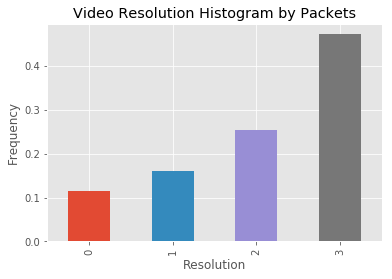

In [16]:
plot_df = video_df['resolution'].value_counts(normalize=True).sort_index()
plot_df.plot(kind='bar')

plt.xlabel('Resolution')
plt.ylabel('Frequency')
plt.title('Video Resolution Histogram by Packets')

plt.show()

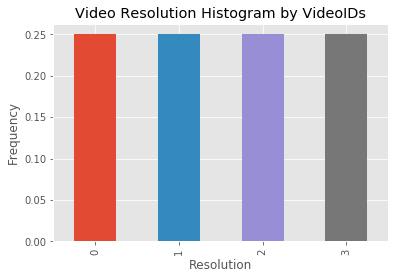

In [17]:
plot_df = model_df['resolution'].value_counts(normalize=True).sort_index()
plot_df.plot(kind='bar')

plt.xlabel('Resolution')
plt.ylabel('Frequency')
plt.title('Video Resolution Histogram by VideoIDs')

plt.show()

Although the video resolution by packets is imbalanced, the data labels for the model are balanced.

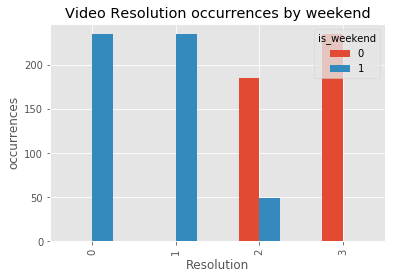

In [18]:
pd.pivot_table(model_df, index= 'resolution', columns= model_df['is_weekend'].astype(str), values= "is_weekend",aggfunc=len) \
.plot(kind= 'bar')

plt.xlabel('Resolution')
plt.ylabel('occurrences')
plt.title('Video Resolution occurrences by weekend')

plt.show()

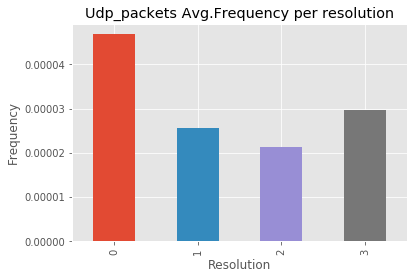

In [19]:
plot_df = model_df.groupby('resolution')['Prc_Udp_packets'].mean()
plot_df.plot(kind='bar')

plt.xlabel('Resolution')
plt.ylabel('Frequency')
plt.title('Udp_packets Avg.Frequency per resolution')

plt.show()

---

# Modelling

### Data Split

In [1]:
from sklearn.model_selection import train_test_split

In [21]:
X = model_df.drop('resolution', axis=1)
y = model_df['resolution']

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

## Fit Different basic ML Models

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [24]:
clf1 = LogisticRegression()
clf2 = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
clf3 = RandomForestClassifier(random_state=1)

classifiers = [('LR',clf1), ('DT',clf2), ('RF', clf3)]
fi_classifiers_list = ['DT', 'RF']

#classifiers = [('DT',clf2)]
#fi_classifiers_list = ['DT', 'RF']


In [25]:
print ("\n===========================================================================================================")
results_train = y_train.to_frame()
results_test = y_test.to_frame()

#fi_df = {}
fi_df = pd.DataFrame(X_train.columns, columns = ['feature'])
confusion_matrixs_train = {}
confusion_matrixs_test = {}

for clf_name, clf in classifiers:
    model = clf.fit(X_train, y_train)
    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)
    
    results_train[clf_name] = clf.predict(X_train)
    results_test[clf_name] = clf.predict(X_test)
    
    print ('{:2} classifier:\n \
        \tTrain Accuracy: {:.2f}\n \
        \tTest Accuracy: {:.2f}'\
               .format(clf_name,
               clf.score(X_train, y_train),
               clf.score(X_test, y_test)))

    # Compute train classification report
    print ("\nTrain Classification Report:")
    print(classification_report(y_true=y_train,
                            y_pred=y_pred_train))
    
    # Compute train confusion matrix
    cnf_matrix_train = confusion_matrix(y_true=y_train, y_pred=results_train[clf_name])
    confusion_matrixs_train[clf_name] = cnf_matrix_train
    
    print ("\nTrain Confusion Matrix:")
    print (pd.DataFrame(cnf_matrix_train,
             index = clf.classes_,
             columns = clf.classes_))
    
    # Compute test classification report    
    print ("\nTest Classification Report:")
    print(classification_report(y_true=y_test,
                            y_pred=y_pred_test))

    # Compute test confusion matrix
    cnf_matrix_test = confusion_matrix(y_true=y_test, y_pred=results_test[clf_name])
    confusion_matrixs_test[clf_name] = cnf_matrix_test

    print ("\nTest Confusion Matrix:")
    print (pd.DataFrame(cnf_matrix_test,
             index = clf.classes_,
             columns = clf.classes_))
    
    # Compute feature importance matrix
    print ("\nFeature Importance by PermutationImportance method:")
    perm = PermutationImportance(clf).fit(X_train, y_train)
    print ( eli5.format_as_text(eli5.explain_weights(perm, top=8, feature_names = X_train.columns.tolist())) )

    if clf_name in fi_classifiers_list:
        fi_df[clf_name+'_fi_score'] = clf.feature_importances_[:, ]
        fi_df[clf_name+'_rel_fi_score'] = fi_df[clf_name+'_fi_score'] / fi_df[clf_name+'_fi_score'].max()
    
    
    print ("\n=================================================================================================")


LR classifier:
         	Train Accuracy: 0.88
         	Test Accuracy: 0.93

Train Classification Report:
              precision    recall  f1-score   support

           0       0.87      1.00      0.93       191
           1       0.78      0.85      0.82       187
           2       0.88      0.77      0.82       192
           3       1.00      0.88      0.94       182

   micro avg       0.88      0.88      0.88       752
   macro avg       0.88      0.88      0.88       752
weighted avg       0.88      0.88      0.88       752


Train Confusion Matrix:
     0    1    2    3
0  191    0    0    0
1   28  159    0    0
2    0   44  148    0
3    0    0   21  161

Test Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        44
           1       0.90      0.92      0.91        48
           2       0.90      0.88      0.89        43
           3       1.00      0.92      0.96        53

   micro avg       0.9

C:\Users\Ayelet\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Ayelet\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)




Feature Importance by PermutationImportance method:
Explained as: feature importances

Feature importances, computed as a decrease in score when feature
values are permuted (i.e. become noise). This is also known as 
permutation importance.

If feature importances are computed on the same data as used for training, 
they don't reflect importance of features for generalization. Use a held-out
dataset if you want generalization feature importances.

0.4580 ± 0.0236  is_weekend
0.1960 ± 0.0096  dow_Friday
0.1848 ± 0.0185  Prc_outbound_payload_kb
0.1755 ± 0.0115  dow_Wednesday
0.0516 ± 0.0043  day_part_dawn
0.0077 ± 0.0020  day_part_evening
     0 ± 0.0000  dow_Thursday
     0 ± 0.0000  day_part_morning
               … 6 more …               

RF classifier:
         	Train Accuracy: 0.95
         	Test Accuracy: 0.97

Train Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.95      0.97       191
           1       0.91      0.9

C:\Users\Ayelet\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Explained as: feature importances

Feature importances, computed as a decrease in score when feature
values are permuted (i.e. become noise). This is also known as 
permutation importance.

If feature importances are computed on the same data as used for training, 
they don't reflect importance of features for generalization. Use a held-out
dataset if you want generalization feature importances.

0.3109 ± 0.0161  is_weekend
0.1862 ± 0.0258  dow_Friday
0.1564 ± 0.0191  dow_Thursday
0.0907 ± 0.0101  day_part_dawn
0.0777 ± 0.0257  Prc_outbound_payload_kb
0.0324 ± 0.0064  day_part_night
0.0234 ± 0.0060  dow_Wednesday
0.0109 ± 0.0091  day_part_evening
               … 6 more …               



In [26]:
print ( results_train.head(2) )
print ( results_test.head(2) )

              resolution LR DT RF
video_id                         
1534491241903          1  1  1  1
1534551832329          1  0  1  1
              resolution LR DT RF
video_id                         
1534362535782          3  3  3  3
1534542918402          1  1  1  1


### Classifiers Confusion matrixs (over train ds) & Feature Importance 

In [27]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    import itertools
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


### Logistic Regression

Logistic Regression Classifier: Train-Ds
Confusion matrix, without normalization


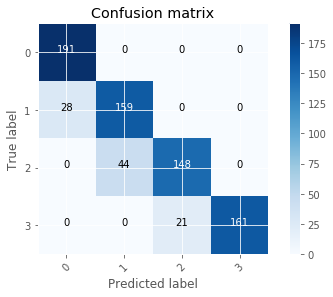

In [28]:
print ('Logistic Regression Classifier: Train-Ds')
plt.figure()
plot_confusion_matrix(confusion_matrixs_train['LR'], classes=clf.classes_,normalize= False,  title='Confusion matrix')

### Decision Tree

Decision Tree Classifier Classifier: Train-Ds
Confusion matrix, without normalization


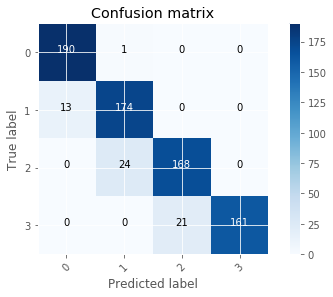

In [29]:
print ('Decision Tree Classifier Classifier: Train-Ds')
plt.figure()
plot_confusion_matrix(confusion_matrixs_train['DT'], classes=clf.classes_,normalize= False,  title='Confusion matrix')

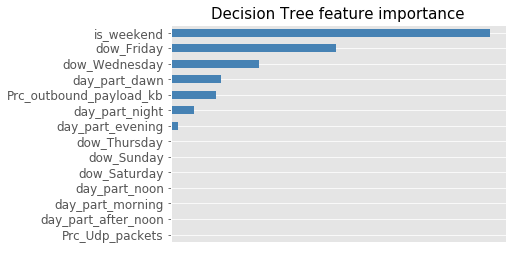

In [30]:
df_dt_fi = fi_df.sort_values('DT_rel_fi_score', ascending = False)
df_dt_fi.sort_values('DT_rel_fi_score', ascending = True) \
.plot(kind='barh', x='feature', y='DT_fi_score', legend=False, color='steelblue')
plt.title('Decision Tree feature importance', fontsize = 15)
plt.xlabel('')
plt.ylabel('')
plt.xticks([], [])
plt.yticks(fontsize=12)
plt.show()

### Random Forest

Random Forest Classifier: Train-Ds
Confusion matrix, without normalization


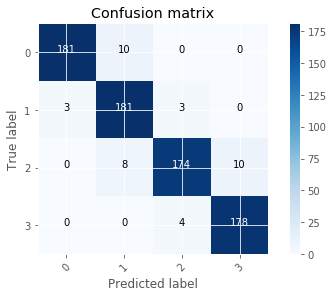

In [31]:
print ('Random Forest Classifier: Train-Ds')
plt.figure()
plot_confusion_matrix(confusion_matrixs_train['RF'], classes=clf.classes_,normalize= False,  title='Confusion matrix')

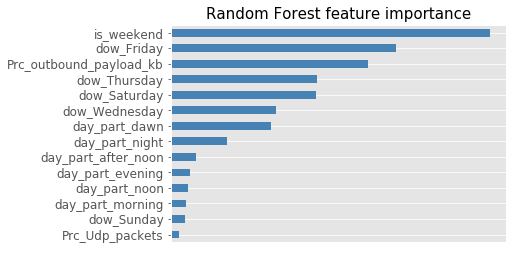

In [32]:
df_rf_fi = fi_df.sort_values('RF_rel_fi_score', ascending = False)
df_rf_fi.sort_values('RF_rel_fi_score', ascending = True) \
.plot(kind='barh', x='feature', y='RF_fi_score', legend=False, color='steelblue')
plt.title('Random Forest feature importance', fontsize = 15)
plt.xlabel('')
plt.ylabel('')
plt.xticks([], [])
plt.yticks(fontsize=12)
plt.show()

# The End